In [1]:
import time
start_time=time.time()

In [2]:
#import sys
#from pathlib import Path
import json
import numpy as np
#import strucfunc
import matplotlib.pyplot as plt
import time
#from astropy.io import fits
import pandas as pd
import seaborn as sns
#import math
#import sys
#import os
#from sabreMod import sosf,sosfh
#from scipy import interpolate
#import itertools
import lmfit

In [3]:
def bfunc00(r, r0, sig2, m):
    "Simple 3-parameter structure function"
    C = 1.0 / (1.0 + (r / r0)**m)
    return 2.0 * sig2 * (1.0 - C)

In [4]:
def bfunc01(r, r0, sig2, m, s0):
    "Structure function with added seeing (scale `s0`)"
    seeing = (np.tanh((r / (2.0 * s0)**2)))**2
    return seeing * bfunc00(r, r0, sig2, m)

In [5]:
data = json.load(open("SFdata//HX.json"))

pixscale = 0.26 # arcsec
pixscale *= 2.4              # parsec
s0 = 0.5                   # parsec
m = 1.4

3.5486155706891322

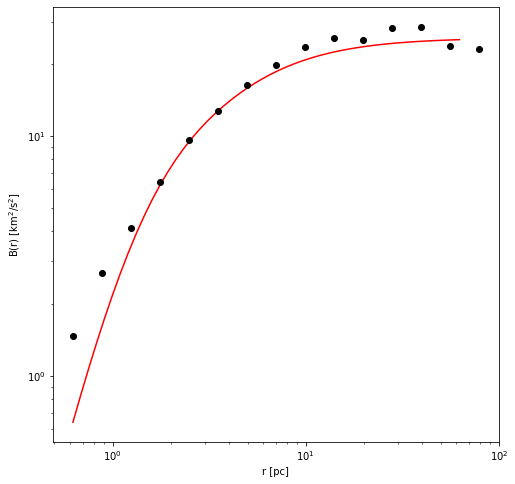

In [6]:
r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]

rgrid = pixscale * np.logspace(0.0, 2)
r0 = np.interp(sig2, B, r)

fig, ax = plt.subplots(figsize=(8, 8))
# Plot fit to unweighted strucfunc
ax.plot(rgrid, bfunc01(rgrid, r0, sig2, m, s0), color="red")
# Plot points from unweighted strucfunc
ax.plot(r, B, 'o',  color='black')

ax.set(
    xscale = "log",
    yscale = "log",
#    ylim  = [1, 250],
#    xlim  = [1, 150],
    xlabel = "r [pc]",
    ylabel = r"B(r) [km$^{2}$/s$^{2}$]",
)

r0

In [7]:
model01 = lmfit.Model(bfunc01)
model01.param_names

['r0', 'sig2', 'm', 's0']

In [8]:
relative_uncertainty = 0.1
weights = 1.0 / (relative_uncertainty * B)
weights[-5:] /= 4.0

In [9]:
for p in model01.param_names:
    model01.set_param_hint(p, min=0.0)
model01.print_param_hints()

Name     Value      Min      Max     Vary    Expr    
m          nan        0      inf     True    
r0         nan        0      inf     True    
s0         nan        0      inf     True    
sig2       nan        0      inf     True    


In [10]:
result2 = model01.fit(
    B, 
    weights=weights,
    r=r, r0=r0, sig2=sig2, m=m, s0=s0
)

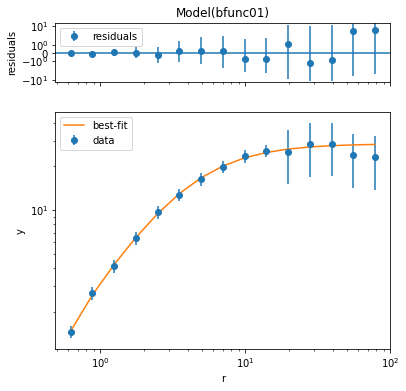

In [11]:
fig, _ = result2.plot()
fig.axes[0].set(
    xscale="log",
    yscale="symlog",
)
fig.axes[1].set(
    xscale="log",
    yscale="log",
);



In [12]:
print(result2.fit_report())

[[Model]]
    Model(bfunc01)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 15
    # variables        = 4
    chi-square         = 0.96949795
    reduced chi-square = 0.08813618
    Akaike info crit   = -33.0854068
    Bayesian info crit = -30.2532060
[[Variables]]
    r0:    3.97388967 +/- 0.22957214 (5.78%) (init = 3.548616)
    sig2:  14.3372397 +/- 0.49491885 (3.45%) (init = 12.89595)
    m:     1.51126247 +/- 0.05391836 (3.57%) (init = 1.4)
    s0:    0.29608568 +/- 0.02333180 (7.88%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(r0, sig2) =  0.947
    C(r0, m)    = -0.900
    C(m, s0)    = -0.813
    C(sig2, m)  = -0.794
    C(r0, s0)   =  0.588
    C(sig2, s0) =  0.528


In [13]:
result2.conf_interval()
print(result2.ci_report())

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 r0  :  -0.68111  -0.43229  -0.21453   3.97389  +0.24343  +0.56858  +1.09463
 sig2:  -1.60944  -0.98955  -0.47839  14.33724  +0.51588  +1.16545  +2.13422
 m   :  -0.20268  -0.11657  -0.05343   1.51126  +0.05211  +0.11020  +0.18058
 s0  :      -inf      -inf  -0.02682   0.29609  +0.02078  +0.04172  +0.06735


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\lmfit\confidence.py:327: UserWarning: rel_change=2.0684269322201498e-07 < 1e-05 at iteration 8 and prob(s0=0.1094312858850881) = 0.9427113183118938 < max(sigmas).
  warn(errmsg)


In [14]:
sig2

12.895954004824253

lmxsig2=sig2*2
lmnsig2=sig2*0.25
lmxr0=r0*2
lmnr0=r0*0.25
lmxm=m*2
lmnm=m*0.25
lmxs0=s0*2
lmns0=s0*0.25

In [15]:
lmxsig2=12
lmnsig2=18
lmxr0=2.5
lmnr0=5.5
lmxm=1.25
lmnm=1.8
lmxs0=0.0
lmns0=1.0

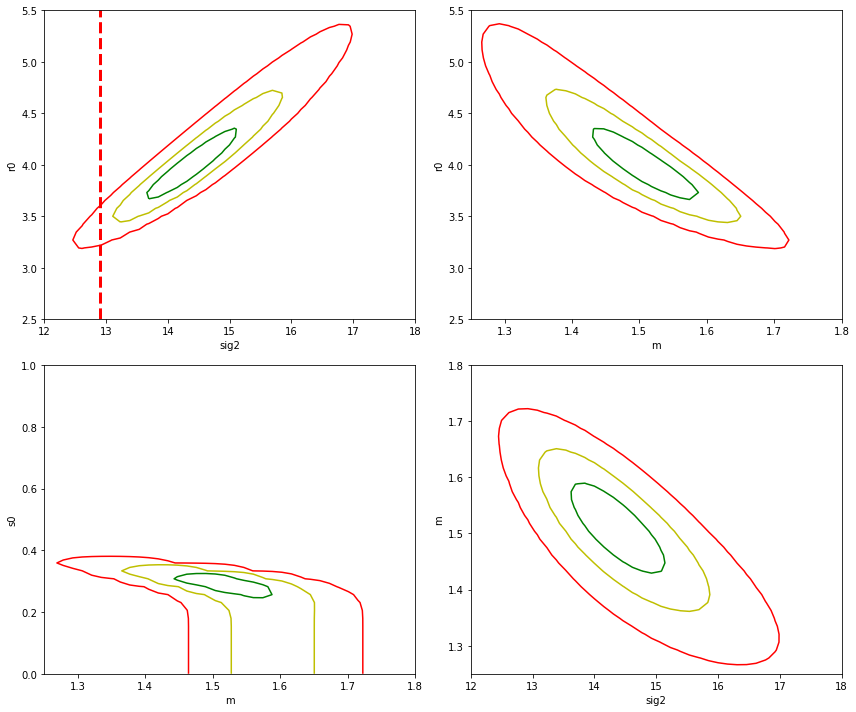

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'r0', 40, 40,
    limits=[[lmnsig2, lmxsig2], [lmnr0, lmxr0]],
)
levels = [0.6827, 0.9545, 0.9973]
colors = ["g", "y", "r"]
ctp = axes[0, 0].contour(cx, cy, grid, levels, colors=colors)
axes[0, 0].axvline(result2.init_params["sig2"].value, color="r", lw=3, ls="dashed")
axes[0, 0].set_xlabel('sig2')
axes[0, 0].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 'r0', 40, 40,
    limits=[[lmnm, lmxm], [lmnr0, lmxr0]],
)
ctp = axes[0, 1].contour(cx, cy, grid, levels, colors=colors)
axes[0, 1].set_xlabel('m')
axes[0, 1].set_ylabel('r0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'm', 's0', 40, 40,
    limits=[[lmnm, lmxm], [lmns0, lmxs0]],
)
ctp = axes[1, 0].contour(cx, cy, grid, levels, colors=colors)
axes[1, 0].set_xlabel('m')
axes[1, 0].set_ylabel('s0')

cx, cy, grid = lmfit.conf_interval2d(
    result2, result2, 'sig2', 'm', 40, 40,
    limits=[[lmnsig2, lmxsig2], [lmnm, lmxm]],
)
ctp = axes[1, 1].contour(cx, cy, grid, levels, colors=colors)
axes[1, 1].set_xlabel('sig2')
axes[1, 1].set_ylabel('m')

fig.tight_layout();

In [17]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 33.17572617530823 seconds ---
